# Use Case Example

This example illustrates a use case that covers the essential steps involved in building a hydrological model and conducting a climate change analysis:

- **Identification of the watershed and its key characteristics**
  - Beaurivage watershed in Southern Quebec, at the location of the 023401 streamflow gauge.
- **Collection of observed data**
  - ERA5-Land and streamflow gauge data.
- **Preparation and calibration of the hydrological model**
  - GR4JCN emulated by the Raven hydrological framework.
- **Calculation of hydrological indicators**
  - Mean summer flow
  - Mean monthly flow
  - 20- and 100-year maximum flow
  - 2-year minimum 7-day average summer flow
- **Assessment of the impact of climate change**
  - Bias-adjusted CMIP6 simulations from the ESPO-G6-R2 dataset

## Identification of a watershed and its characteristics

<div class="alert alert-info"> <b>INFO</b>

For more information on this section and available options, consult the [GIS module page](https://xhydro.readthedocs.io/en/latest/notebooks/gis.html#GIS-module).

</div>

This first step is highly dependent on the hydrological model. Since we will use GR4JCN in our example, we need to obtain the drainage area, centroid coordinates, and elevation. We'll also need the watershed delineation to extract the meteorological data.

- Delineation of the watershed and basic characteristics: `xhydro.gis.watershed_delineation` and `xhydro.gis.watershed_properties`
- Elevation: `xhydro.gis.surface_properties`

In [1]:
# Workaround for determining the notebook folder within a running notebook
# This cell is not visible when the documentation is built.

from __future__ import annotations

try:
    from _finder import _find_current_folder

    notebook_folder = _find_current_folder()
except ImportError:
    from pathlib import Path

    notebook_folder = Path().cwd()

(notebook_folder / "_data").mkdir(exist_ok=True)

In [2]:
import leafmap
import numpy as np
import pandas as pd

import xhydro.gis as xhgis

In [3]:
# Watershed delineation
coords = (-71.28878, 46.65692)
m = leafmap.Map(center=(coords[1], coords[0]), zoom=8)
gdf = xhgis.watershed_delineation(coordinates=coords, map=m)
gdf

HYBAS_ID  Upstream Area (sq. km).  \
0  7120365812                    693.5   

                                            geometry  category    color  
0  POLYGON ((-71.09758 46.40035, -71.09409 46.403...         1  #ffffd9

Showing `m` will output this map:
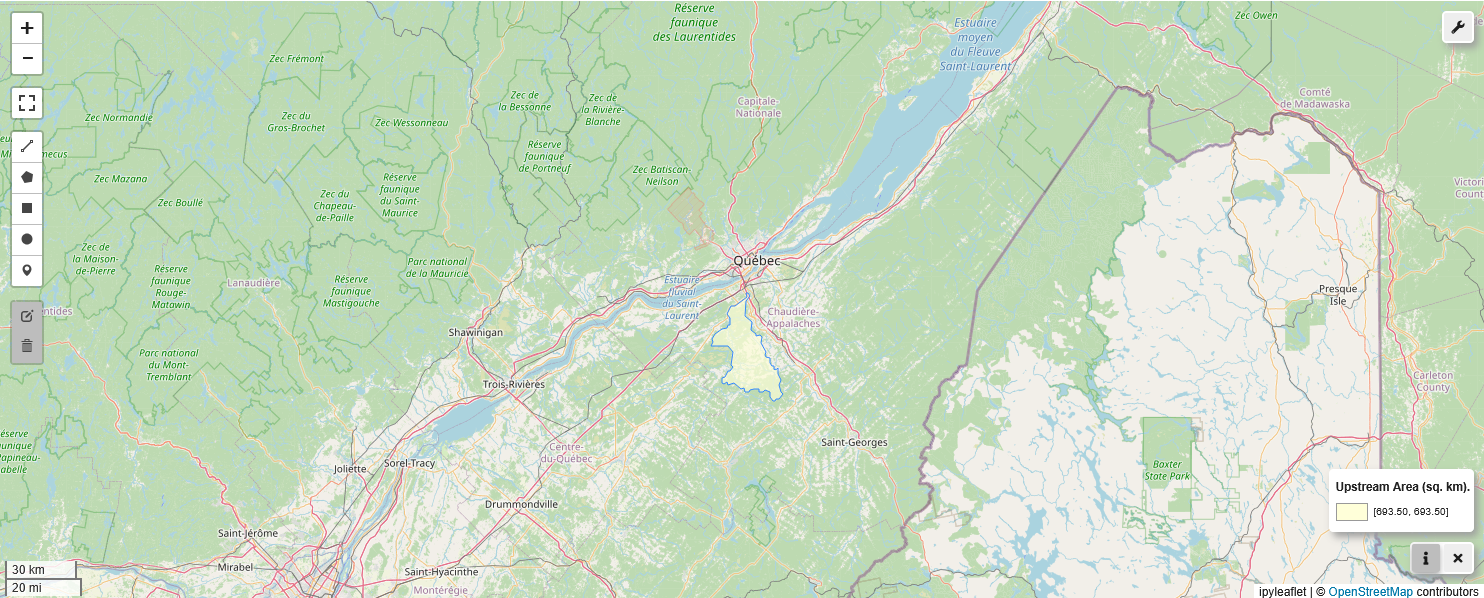

In [4]:
# Watershed properties
gdf_wat = xhgis.watershed_properties(gdf)
gdf_wat

HYBAS_ID  Upstream Area (sq. km).  category    color          area  \
0  7120365812                    693.5         1  #ffffd9  5.845762e+08   

       perimeter  gravelius                                 centroid  
0  158155.350574   1.845263  (-71.26046365140014, 46.45216102567744)

In [5]:
# Surface properties
gdf_surf = xhgis.surface_properties(gdf)
gdf_surf

elevation     slope      aspect  gsd proj:shape  epsg  band  \
geometry                                                                 
0         224.201508  1.416482  214.740387   90     {1200}  4326  data   

                                             proj:transform           title  \
geometry                                                                      
0         {0.0, -0.0008333333333333334, 47.0004166666666...  N46_00_W072_00   

               time                                        id  proj:epsg  \
geometry                                                                   
0        2021-04-22  Copernicus_DSM_COG_30_N46_00_W072_00_DEM       4326   

          platform  spatial_ref  
geometry                         
0         TanDEM-X            0

We'll keep the necessary information and format it for GR4JCN.

In [6]:
drainage_area = np.array([gdf_wat["Upstream Area (sq. km)."].iloc[0]])
latitude = np.array([gdf_wat.centroid[0][1]])
longitude = np.array([gdf_wat.centroid[0][0]])
elevation = np.array([gdf_surf["elevation"].iloc[0]])

Since `xhgis.watershed_delineation` extracts the nearest HydroBASINS polygon, the watershed might not exactly correspond to the requested coordinates. The 023401 streamflow gauge as an associated drainage area of 708 km², which differs from our results. Streamflow will have to be adjusted using an area scaling factor.

In [7]:
gauge_area = 708
scaling_factor = drainage_area / gauge_area
scaling_factor

array([0.97951977])

## Collection of observed data

In [8]:
import geopandas as gpd
import hvplot.xarray
import matplotlib.pyplot as plt
import xarray as xr

# For easy access to the specific streamflow data used here
import xdatasets
import xscen

### Meteorological data

<div class="alert alert-info"> <b>INFO</b>

Multiple libraries could be used to perform these steps. For simplicity, this example will use the [`subset`](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Defining-the-region) and [`aggregate` modules of the xscen](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Spatial-mean) library.

</div>

This example will use daily ERA5-Land data hosted on the PAVICS platform.

In [9]:
# Extraction of ERA5-Land data
meteo_ref = xr.open_dataset(
    "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml",
    engine="netcdf4",
    chunks={"time": 365, "lon": 50, "lat": 50},
)[["pr", "tasmin", "tasmax"]]
meteo_ref

<xarray.Dataset> Size: 429GB
Dimensions:  (time: 26298, lat: 800, lon: 1700)
Coordinates:
  * lat      (lat) float32 3kB 10.0 10.1 10.2 10.3 10.4 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float32 7kB -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 210kB 1950-01-01 1950-01-02 ... 2021-12-31
Data variables:
    pr       (time, lat, lon) float32 143GB dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 143GB dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 143GB dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes: (12/26)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    dataset_description:  https://www.ecmwf.int/en/era5-land
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac

That dataset covers the entire globe and has more than 70 years of data. The first step will thus be to subset the dataset both spatially and temporally. For the spatial subset, the GeoDataFrame obtained earlier can be used.

In [10]:
meteo_ref = meteo_ref.sel(time=slice("1991", "2020"))  # Temporal subsetting
meteo_ref = xscen.spatial.subset(
    meteo_ref, method="shape", tile_buffer=2, shape=gdf
)  # Spatial subsetting, with a buffer of 2 grid cells
meteo_ref = meteo_ref.assign_coords({"crs": meteo_ref.crs})
meteo_ref

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 10958, lat: 8, lon: 8)
Coordinates:
  * lat      (lat) float32 32B 46.1 46.2 46.3 46.4 46.5 46.6 46.7 46.8
  * lon      (lon) float32 32B -71.6 -71.5 -71.4 -71.3 -71.2 -71.1 -71.0 -70.9
  * time     (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
    crs      int64 8B 1
Data variables:
    pr       (time, lat, lon) float32 3MB dask.array<chunksize=(355, 8, 8), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 3MB dask.array<chunksize=(355, 8, 8), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 3MB dask.array<chunksize=(355, 8, 8), meta=np.ndarray>
Attributes: (12/27)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac
    crs:                  EPSG:4326

<Axes: title={'center': 'time = 1991-01-01, crs = 1'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

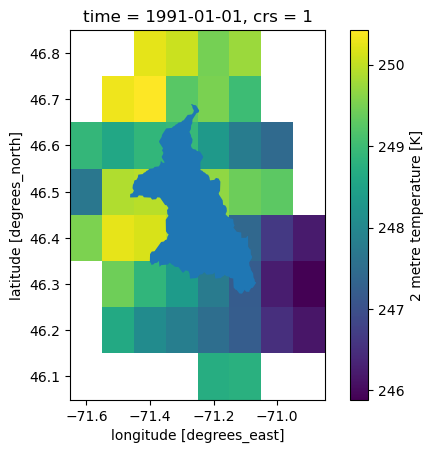

In [11]:
ax = plt.subplot(1, 1, 1)
meteo_ref.tasmin.isel(time=0).plot(ax=ax)
gdf.plot(ax=ax)

Since GR4JCN is a lumped model, we need to average the meteo over the watershed. This will be accomplished using `xscen.spatial_mean`. Multiple methods exist, but for shapefiles, the most accurate is "xesmf", which calls upon [xESMF's SpatialAverager](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Spatial_Averaging.html) to accurately follow each grid cell's representation over the polygon. It can be very slow for detailed polygons with lots of vertices, but the "simplify_tolerance" argument helps speed up that process.

In [12]:
meteo_ref = xscen.spatial_mean(
    meteo_ref,
    method="xesmf",
    region={"method": "shape", "shape": gdf},
    simplify_tolerance=0.1,
)

# Some housekeeping to associate the HYBAS_ID dimension (coming from the shapefile) to other coordinates added from the GeoDataFrame.
for c in meteo_ref.coords:
    if len(meteo_ref[c].dims) == 0:
        if c not in ["lon", "lat"]:
            meteo_ref = meteo_ref.drop_vars([c])
        else:
            meteo_ref[c] = meteo_ref[c].expand_dims("HYBAS_ID")
meteo_ref

<xarray.Dataset> Size: 219kB
Dimensions:   (time: 10958, HYBAS_ID: 1)
Coordinates:
  * time      (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
    lon       (HYBAS_ID) float64 8B -71.28
    lat       (HYBAS_ID) float64 8B 46.46
  * HYBAS_ID  (HYBAS_ID) int64 8B 7120365812
Data variables:
    pr        (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
    tasmin    (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
    tasmax    (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac
    crs:                  EPSG:4326
    regrid_method:        conservative

Raven expects temperatures in Celsius and precipitation in millimetres, but they currently are in CF-compliant Kelvin and kg m-2 s-1, respectively. Once again, `xscen` can be used for that operation.

In [13]:
meteo_ref = xscen.utils.change_units(
    meteo_ref, {"tasmax": "degC", "tasmin": "degC", "pr": "mm"}
)

In [14]:
# Save
meteo_ref.to_netcdf(notebook_folder / "_data" / "meteo.nc")

### Hydrometric data

Gauge streamflow data from the Quebec government can be accessed through the `xdatasets` library.

In [15]:
qobs = (
    xdatasets.Query(
        **{
            "datasets": {
                "deh": {
                    "id": ["023401"],
                    "variables": ["streamflow"],
                }
            },
            "time": {"start": "1991-01-01", "end": "2020-12-31"},
        }
    )
    .data.squeeze()
    .load()
).sel(spatial_agg="watershed")

In [16]:
# Once again, some housekeeping is required on the metadata to make sure that xHydro understands the dataset.
qobs["id"].attrs["cf_role"] = "timeseries_id"
qobs = qobs.rename({"id": "station_id"})
qobs["streamflow"].attrs = {
    "long_name": "Streamflow",
    "units": "m3 s-1",
    "standard_name": "water_volume_transport_in_river_channel",
    "cell_methods": "time: mean",
}
for c in qobs.coords:
    if len(qobs[c].dims) == 0 and "time" not in c:
        qobs[c] = qobs[c].expand_dims("station_id")

qobs

<xarray.Dataset> Size: 132kB
Dimensions:        (time: 10958, station_id: 1)
Coordinates: (12/15)
    drainage_area  (station_id) float32 4B 708.0
    end_date       (station_id) datetime64[ns] 8B 2020-12-31
  * station_id     (station_id) <U6 24B '023401'
    latitude       (station_id) float32 4B 46.66
    longitude      (station_id) float32 4B -71.29
    name           (station_id) object 8B 'Beaurivage'
    ...             ...
    spatial_agg    (station_id) <U9 36B 'watershed'
    start_date     (station_id) datetime64[ns] 8B 1991-01-01
  * time           (time) datetime64[ns] 88kB 1991-01-01 ... 2020-12-31
    time_agg       <U4 16B 'mean'
    timestep       <U1 4B 'D'
    variable       (station_id) <U10 40B 'streamflow'
Data variables:
    streamflow     (time) float32 44kB 46.0 33.9 26.2 21.0 ... 19.98 15.76 12.93

In [17]:
qobs.streamflow.hvplot()

:Curve   [time]   (Streamflow)

As specified earlier, streamflow observations need to be modified to account for the differences in watershed sizes between the gauge and the polygon.

In [18]:
with xr.set_options(keep_attrs=True):
    qobs["streamflow"] = qobs["streamflow"] * scaling_factor

In [19]:
# Save (necessary for model calibration)
qobs.to_netcdf(notebook_folder / "_data" / "qobs.nc")

## Preparation and calibration of the hydrological model (xhydro.modelling)

<div class="alert alert-info"> <b>INFO</b>

For more information on this section and available options, consult the [Hydrological modelling module page](https://xhydro.readthedocs.io/en/latest/notebooks/hydrological_modelling.html).

</div>

In [20]:
from xhydro.modelling.calibration import perform_calibration
from xhydro.modelling.obj_funcs import get_objective_function

The `perform_calibration` function requires a `model_config` argument that allows it to build the corresponding hydrological model. All the required information has been acquired in previous sections, so it is only a matter of filling in the entries of the RavenPy/GR4JCN model.

For simplification matters, the meteorological station's elevation will be set as the real watershed's average elevation. Computing grid cell elevation in ERA5-Land is not always trivial and is not within the scope of this example. Similarly, snow water equivalent is not currently available on PAVICS' database, so "AVG_ANNUAL_SNOW" was roughly estimated using [Brown & Brasnett (2010)](https://ccin.ca/ccw/snow/overview/references).

In [21]:
# Model configuration
model_config = {
    "model_name": "GR4JCN",
    "parameters": [0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    "drainage_area": drainage_area,
    "elevation": elevation,
    "latitude": latitude,
    "longitude": longitude,
    "start_date": "1991-01-01",
    "end_date": "2020-12-31",
    "meteo_file": notebook_folder / "_data" / "meteo.nc",
    "data_type": ["TEMP_MAX", "TEMP_MIN", "PRECIP"],
    "alt_names_meteo": {"TEMP_MIN": "tasmin", "TEMP_MAX": "tasmax", "PRECIP": "pr"},
    "meteo_station_properties": {
        "ALL": {"elevation": elevation, "latitude": latitude, "longitude": longitude}
    },
    "rain_snow_fraction": "RAINSNOW_DINGMAN",
    "evaporation": "PET_HARGREAVES_1985",
    "global_parameter": {"AVG_ANNUAL_SNOW": 100.00},
}

# Parameter bounds for GR4JCN
bounds_low = [0.01, -15.0, 10.0, 0.0, 1.0, 0.0]
bounds_high = [2.5, 10.0, 700.0, 7.0, 30.0, 1.0]

In [22]:
# Calibration / validation period
mask_calib = xr.where(qobs.time.dt.year <= 2010, 1, 0).values
mask_valid = xr.where(qobs.time.dt.year > 2010, 1, 0).values

# Model calibration
best_parameters, best_simulation, best_objfun = perform_calibration(
    model_config,
    "kge",
    qobs=notebook_folder / "_data" / "qobs.nc",
    bounds_low=bounds_low,
    bounds_high=bounds_high,
    evaluations=150,
    algorithm="DDS",
    mask=mask_calib,
    sampler_kwargs=dict(trials=1),
)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  150  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 150 repetitions...
Finding best starting point for trial 1 using 5 random samples.
1 of 150, maximal objective function=0.0641755, time remaining: 00:14:43
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 150, maximal objective function=0.362014, time remaining: 00:15:29
3 of 150, maximal objective function=0.362014, time remaining: 00:15:42
4 of 150, maximal objective function=0.362014, time remaining: 00:16:09
5 of 150, maximal objective function=0.362014, time remaining: 00:16:26
6 of 150, maximal objective function=0.440717, time remaining: 00:16:29
7 of 150, maximal objective function=0.440717, time remaining: 00:16:27
8 of 150, maximal objective function=0.440717, time remaining: 00:16:37
9 of 150, maximal objective function=0.440717, time remaining: 00:16:30
10 of 150, maximal objective fun

The real KGE should be computed from a validation period, using `get_objective_function`.

In [23]:
get_objective_function(
    qobs=qobs.streamflow,
    qsim=best_simulation,
    obj_func="kge",
    mask=mask_valid,
).values

array(0.70054743)

In [24]:
ax = plt.figure(figsize=(15, 10))
qobs.streamflow.hvplot(color="k", line_width=3) * best_simulation.streamflow.hvplot(
    color="r"
)

:Overlay
   .Curve.I  :Curve   [time]   (Streamflow)
   .Curve.II :Curve   [time]   (Simulated outflows)

<Figure size 1500x1000 with 0 Axes>

## Calculation of hydroclimatological indicators

In [25]:
import xclim

import xhydro as xh
import xhydro.frequency_analysis as xhfa

### Non-frequential indicators

<div class="alert alert-info"> <b>INFO</b>

For more information on this section and available options, consult the [Climate change analysis page](https://xhydro.readthedocs.io/en/latest/notebooks/climate_change.html).

Custom indicators in `xHydro` are built by following the YAML formatting required by `xclim`. More information is available [in the xclim documentation](https://xclim.readthedocs.io/en/latest/api.html#yaml-file-structure). The list of Yaml IDs is available [here](https://xclim.readthedocs.io/en/stable/indicators.html).

</div>

For a climate change impact analysis, the typical process to compute non-frequential indicators would be to:

1. Define the indicators either through the `xclim` functionalities shown below or through a [YAML file](https://xclim.readthedocs.io/en/latest/api.html#yaml-file-structure).
2. Call `xhydro.indicators.compute_indicators`, which would produce annual results through a dictionary, where each key represents the requested frequencies.
3. Call `xhydro.cc.climatological_op` on each entry of the dictionary to compute the 30-year average.
4. Recombine the datasets.

However, if the annual results are not required, `xhydro.cc.produce_horizon` can bypass steps 2 to 4 and alleviate a lot of hassle. It accomplishes that by removing the `time` axis and replacing it for a `horizon` dimension that represents a slice of time. In the case of seasonal or monthly indicators, a corresponding `season` or `month` dimension is also added.

We will compute the mean summer flow (an annual indicator) and mean monthly flows.

In [26]:
indicators = [
    # Mean summer flow
    xclim.core.indicator.Indicator.from_dict(
        data={
            "base": "stats",
            "input": {"da": "streamflow"},
            "parameters": {"op": "mean", "indexer": {"month": [6, 7, 8]}},
        },
        identifier="qmoy_summer",
        module="hydro",
    ),
    # Mean monthly flow
    xclim.core.indicator.Indicator.from_dict(
        data={
            "base": "stats",
            "input": {"da": "streamflow"},
            "parameters": {"op": "mean", "freq": "MS"},
        },
        identifier="qmoy_monthly",
        module="hydro",
    ),
]

ds_indicators = xh.cc.produce_horizon(
    best_simulation, indicators=indicators, periods=["1991", "2020"]
)

In [27]:
ds_indicators

<xarray.Dataset> Size: 312B
Dimensions:       (horizon: 1, month: 12)
Coordinates:
    basin_name    <U7 28B 'sub_001'
  * horizon       (horizon) <U9 36B '1991-2020'
  * month         (month) <U3 144B 'JAN' 'FEB' 'MAR' 'APR' ... 'OCT' 'NOV' 'DEC'
Data variables:
    qmoy_summer   (horizon) float64 8B 10.2
    qmoy_monthly  (horizon, month) float64 96B 6.967 4.774 12.49 ... 16.08 11.52
Attributes:
    cat:xrfreq:            fx
    cat:frequency:         fx
    cat:processing_level:  horizons
    cat:variable:          ('qmoy_monthly',)

### Frequency analysis

<div class="alert alert-info"> <b>INFO</b>

For more information on this section and available options, consult the [Local frequency analysis page](https://xhydro.readthedocs.io/en/latest/notebooks/local_frequency_analysis.html).

</div>

A frequency analysis typically follows these steps:

1. Get the raw data needed for the analysis, such as annual maximums, through `xhydro.indicators.get_yearly_op`.
2. Call `xhfa.local.fit` to obtain the parameters for a specified number of distributions, such as Gumbel, GEV, and Pearson-III.
3. (Optional) Call `xhfa.local.criteria` to obtain goodness-of-fit parameters.
4. Call `xhfa.local.parametric_quantiles` to obtain the return levels.

We will compute the 20 and 100-year annual maximums, as well as the 2-year minimum 7-day summer flow.

In [28]:
qref_max = xh.indicators.get_yearly_op(
    best_simulation,
    op="max",
    timeargs={"annual": {}},
    missing="pct",
    missing_options={"tolerance": 0.15},
)
qref_min = xh.indicators.get_yearly_op(
    best_simulation,
    op="min",
    window=7,
    timeargs={"summer": {"date_bounds": ["05-01", "11-30"]}},
    missing="pct",
    missing_options={"tolerance": 0.15},
)

In [29]:
ax = plt.figure(figsize=(15, 10))
qref_max.streamflow_max_annual.dropna(
    "time", how="all"
).hvplot() * qref_min.streamflow7_min_summer.dropna("time", how="all").hvplot()

:Overlay
   .Curve.I  :Curve   [time]   (Maximum of variable)
   .Curve.II :Curve   [time]   (Minimum of variable)

<Figure size 1500x1000 with 0 Axes>

In [30]:
params_max = xhfa.local.fit(
    qref_max,
    distributions=["genextreme", "gumbel_r", "norm", "pearson3"],
    method="MLE",
    min_years=20,
).compute()
params_min = xhfa.local.fit(
    qref_min,
    distributions=["genextreme", "gumbel_r", "norm", "pearson3"],
    method="MLE",
    min_years=20,
).compute()

params_max

<xarray.Dataset> Size: 432B
Dimensions:                (scipy_dist: 4, dparams: 4)
Coordinates:
    horizon                <U9 36B '1991-2020'
  * dparams                (dparams) <U5 80B 'c' 'skew' 'loc' 'scale'
  * scipy_dist             (scipy_dist) <U10 160B 'genextreme' ... 'pearson3'
    basin_name             <U7 28B 'sub_001'
Data variables:
    streamflow_max_annual  (scipy_dist, dparams) float64 128B -0.1352 ... 129.4
Attributes:
    cat:xrfreq:            YS-JAN
    cat:frequency:         yr
    cat:processing_level:  indicators
    cat:variable:          ('streamflow_max_annual',)
    cat:id:

While not foolproof, the best fit can be identified using the Bayesian Information Criteria.

In [31]:
criteria_max = xhfa.local.criteria(qref_max, params_max)
criteria_max = str(
    criteria_max.isel(
        scipy_dist=criteria_max.streamflow_max_annual.sel(criterion="bic")
        .argmin()
        .values
    ).scipy_dist.values
)  # Get the best fit as a string
print(f"Best distribution for the annual maxima: {criteria_max}")

criteria_min = xhfa.local.criteria(qref_min, params_min)
criteria_min = str(
    criteria_min.isel(
        scipy_dist=criteria_min.streamflow7_min_summer.sel(criterion="bic")
        .argmin()
        .values
    ).scipy_dist.values
)  # Get the best fit as a string
print(f"Best distribution for the summer 7-day minima: {criteria_min}")

Best distribution for the annual maxima: pearson3
Best distribution for the summer 7-day minima: genextreme


In [32]:
# Plotting
data_max = xhfa.local._prepare_plots(
    params_max, xmin=1, xmax=1000, npoints=50, log=True
)
data_max["streamflow_max_annual"].attrs["long_name"] = "streamflow"
pp = xhfa.local._get_plotting_positions(qref_max[["streamflow_max_annual"]])

data_max.streamflow_max_annual.sel(scipy_dist=criteria_max).hvplot(
    x="return_period", grid=True, groupby=[], logx=True, color="k"
) * pp.hvplot.scatter(
    x="streamflow_max_annual_pp",
    y="streamflow_max_annual",
    grid=True,
    groupby=[],
    logx=True,
    color="k",
)

:Overlay
   .Curve.I   :Curve   [return_period]   (streamflow)
   .Scatter.I :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)

In [33]:
# Plotting
data_min = xhfa.local._prepare_plots(
    params_min, xmin=1, xmax=1000, npoints=50, log=True
)
data_min["streamflow7_min_summer"].attrs["long_name"] = "streamflow"
pp = xhfa.local._get_plotting_positions(qref_min[["streamflow7_min_summer"]])

data_min.streamflow7_min_summer.sel(scipy_dist=criteria_min).hvplot(
    x="return_period", grid=True, groupby=[], logx=True, color="k"
) * pp.hvplot.scatter(
    x="streamflow7_min_summer_pp",
    y="streamflow7_min_summer",
    grid=True,
    groupby=[],
    logx=True,
    color="k",
)

:Overlay
   .Curve.I   :Curve   [return_period]   (streamflow)
   .Scatter.I :Scatter   [streamflow7_min_summer_pp]   (Minimum of variable)

In [34]:
# Computation of return levels
rl_max = xhfa.local.parametric_quantiles(
    params_max.sel(scipy_dist=criteria_max).expand_dims("scipy_dist"), t=[20, 100]
).squeeze()
rl_min = xhfa.local.parametric_quantiles(
    params_min.sel(scipy_dist=criteria_min).expand_dims("scipy_dist"), t=[2], mode="min"
).squeeze()
rl_max

<xarray.Dataset> Size: 144B
Dimensions:                (return_period: 2)
Coordinates:
    horizon                <U9 36B '1991-2020'
    scipy_dist             <U8 32B 'pearson3'
    basin_name             <U7 28B 'sub_001'
  * return_period          (return_period) int64 16B 20 100
    p_quantile             (return_period) float64 16B 0.95 0.99
Data variables:
    streamflow_max_annual  (return_period) float64 16B 478.1 689.4
Attributes:
    cat:xrfreq:            YS-JAN
    cat:frequency:         yr
    cat:processing_level:  indicators
    cat:variable:          ('streamflow_max_annual',)
    cat:id:

In [35]:
print(
    f"20-year annual maximum: {np.round(rl_max.streamflow_max_annual.sel(return_period=20).values, 1)} m³/s"
)
print(
    f"100-year annual maximum: {np.round(rl_max.streamflow_max_annual.sel(return_period=100).values, 1)} m³/s"
)
print(
    f"2-year minimum 7-day summer flow: {np.round(rl_min.streamflow7_min_summer.values, 1)} m³/s"
)

20-year annual maximum: 478.1 m³/s
100-year annual maximum: 689.4 m³/s
2-year minimum 7-day summer flow: 3.6 m³/s


## Future streamflow simulations and indicators

### Future meteorological data

Now that we have access to a calibrated hydrological model and historical indicators, we can perform the climate change analysis. This example will use a set of CMIP6 models that have been bias adjusted using ERA5-Land, for consistency with the reference product. Specifically, we will use the ESPO-G6-R2 dataset, also hosted on PAVICS. While it is recommended to use multiple emission scenarios, this example will only use the SSP2-4.5 simulations from 14 climate models.

We can mostly reuse the same code as above. One difference is that climate models often use custom calendars that need to be converted back to standard ones. Once again, `xscen` can be used for that.

In [36]:
models = [
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_CAS_FGOALS-g3_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_CMCC_CMCC-ESM2_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_CSIRO-ARCCSS_ACCESS-CM2_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_CSIRO_ACCESS-ESM1-5_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_DKRZ_MPI-ESM1-2-HR_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_INM_INM-CM5-0_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_MIROC_MIROC6_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_MPI-M_MPI-ESM1-2-LR_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_MRI_MRI-ESM2-0_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_NCC_NorESM2-LM_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_CNRM-CERFACS_CNRM-ESM2-1_ssp245_r1i1p1f2_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_NIMS-KMA_KACE-1-0-G_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_NOAA-GFDL_GFDL-ESM4_ssp245_r1i1p1f1_1950-2100.ncml",
    "day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_BCC_BCC-CSM2-MR_ssp245_r1i1p1f1_1950-2100.ncml",
]

In [37]:
def _prepare_climate(model):
    meteo_sim = xr.open_dataset(
        f"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-E5Lv1.0.0/{model}",
        engine="netcdf4",
        chunks={"time": 365, "lon": 50, "lat": 50},
    )
    meteo_sim = xscen.spatial.subset(
        meteo_sim, method="shape", tile_buffer=2, shape=gdf
    )
    meteo_sim = meteo_sim.assign_coords({"crs": meteo_sim.crs})
    meteo_sim = xscen.spatial_mean(
        meteo_sim,
        method="xesmf",
        region={"method": "shape", "shape": gdf},
        simplify_tolerance=0.1,
    )
    for c in meteo_sim.coords:
        if len(meteo_sim[c].dims) == 0:
            if c not in ["lon", "lat"]:
                meteo_sim = meteo_sim.drop_vars([c])
            else:
                meteo_sim[c] = meteo_sim[c].expand_dims("HYBAS_ID")

    meteo_sim = xscen.utils.change_units(
        meteo_sim, {"tasmax": "degC", "tasmin": "degC", "pr": "mm"}
    )

    # Manage calendars
    meteo_sim = xscen.utils.clean_up(
        meteo_sim,
        convert_calendar_kwargs={"calendar": "standard", "align_on": "random"},
        missing_by_var={"tasmin": "interpolate", "tasmax": "interpolate", "pr": 0},
    )

    return meteo_sim


for i, model in enumerate(models):
    out = _prepare_climate(model)
    out.to_netcdf(notebook_folder / "_data" / f"meteo_sim{i}.nc")

In [38]:
out.pr.hvplot()

:Curve   [time]   (Mean daily precipitation flux)

### Future streamflow data

Once again, the same code as before can be roughly reused here, but with `xhydro.modelling.hydrological_model`. The main difference is that the best parameters can be used when setting up the hydrological model, and that the dates are the full range going to 2100.

In [39]:
from copy import deepcopy

import xhydro.modelling as xhm

In [40]:
model_config = {
    "model_name": "GR4JCN",
    "parameters": np.array(best_parameters),
    "drainage_area": drainage_area,
    "elevation": elevation,
    "latitude": latitude,
    "longitude": longitude,
    "start_date": "1991-01-01",
    "end_date": "2099-12-31",
    "meteo_file": "meteo_sim.nc",
    "data_type": ["TEMP_MAX", "TEMP_MIN", "PRECIP"],
    "alt_names_meteo": {"TEMP_MIN": "tasmin", "TEMP_MAX": "tasmax", "PRECIP": "pr"},
    "meteo_station_properties": {
        "ALL": {"elevation": elevation, "latitude": latitude, "longitude": longitude}
    },
    "rain_snow_fraction": "RAINSNOW_DINGMAN",
    "evaporation": "PET_HARGREAVES_1985",
    "global_parameter": {"AVG_ANNUAL_SNOW": 100.00},
}

In [41]:
# Model execution
for i in range(len(models)):
    model_cfg = deepcopy(model_config)
    model_cfg["meteo_file"] = notebook_folder / "_data" / f"meteo_sim{i}.nc"
    qsim = xhm.hydrological_model(model_cfg).run()
    qsim.to_netcdf(notebook_folder / "_data" / f"qsim{i}.nc")

In [42]:
qsim.streamflow.hvplot()

:Curve   [time]   (Simulated outflows)

### Future hydrological indicators

The same code as before can mainly be used again, with the addition of using a list of periods in the `periods` argument to create a `horizon` dimension. The `xhydro.frequency_analysis.fit` function can also accept a `periods` argument.

In [43]:
for i in range(len(models)):
    qsim_data = xr.open_dataset(notebook_folder / "_data" / f"qsim{i}.nc")

    # Non-frequential indicators
    ds_indicators = xh.cc.produce_horizon(
        qsim_data, indicators=indicators, periods=[["1991", "2020"], ["2070", "2099"]]
    )

    # Frequency analysis
    qsim_max = xh.indicators.get_yearly_op(
        qsim_data,
        op="max",
        timeargs={"annual": {}},
        missing="pct",
        missing_options={"tolerance": 0.15},
    )
    qsim_min = xh.indicators.get_yearly_op(
        qsim_data,
        op="min",
        window=7,
        timeargs={"summer": {"date_bounds": ["05-01", "11-30"]}},
        missing="pct",
        missing_options={"tolerance": 0.15},
    )

    params_max = xhfa.local.fit(
        qsim_max,
        distributions=["genextreme", "gumbel_r", "norm", "pearson3"],
        method="MLE",
        min_years=20,
        periods=[["1991", "2020"], ["2070", "2099"]],
    ).compute()
    params_min = xhfa.local.fit(
        qsim_min,
        distributions=["genextreme", "gumbel_r", "norm", "pearson3"],
        method="MLE",
        min_years=20,
        periods=[["1991", "2020"], ["2070", "2099"]],
    ).compute()

    criteria_max = xhfa.local.criteria(
        qsim_max.sel(time=slice("1991", "2020")), params_max.sel(horizon="1991-2020")
    )
    criteria_max = str(
        criteria_max.isel(
            scipy_dist=criteria_max.streamflow_max_annual.sel(criterion="bic")
            .argmin()
            .values
        ).scipy_dist.values
    )  # Get the best fit as a string

    criteria_min = xhfa.local.criteria(
        qsim_min.sel(time=slice("1991", "2020")), params_min.sel(horizon="1991-2020")
    )
    criteria_min = str(
        criteria_min.isel(
            scipy_dist=criteria_min.streamflow7_min_summer.sel(criterion="bic")
            .argmin()
            .values
        ).scipy_dist.values
    )  # Get the best fit as a string

    # Computation of return levels
    rl_max = xhfa.local.parametric_quantiles(
        params_max.sel(scipy_dist=criteria_max).expand_dims("scipy_dist"), t=[20, 100]
    ).squeeze()
    rl_min = xhfa.local.parametric_quantiles(
        params_min.sel(scipy_dist=criteria_min).expand_dims("scipy_dist"),
        t=[2],
        mode="min",
    ).squeeze()

    ds_indicators = xr.merge([ds_indicators, rl_max, rl_min], compat="override")

    # Save
    ds_indicators.to_netcdf(notebook_folder / "_data" / f"ind_sim{i}.nc")

ds_indicators

<xarray.Dataset> Size: 564B
Dimensions:                 (horizon: 2, month: 12, return_period: 2)
Coordinates:
    basin_name              <U7 28B 'sub_001'
  * horizon                 (horizon) <U9 72B '1991-2020' '2070-2099'
  * month                   (month) <U3 144B 'JAN' 'FEB' 'MAR' ... 'NOV' 'DEC'
    scipy_dist              <U8 32B 'pearson3'
  * return_period           (return_period) int64 16B 20 100
    p_quantile              (return_period) float64 16B 0.95 0.99
Data variables:
    qmoy_summer             (horizon) float64 16B 10.77 9.373
    qmoy_monthly            (horizon, month) float64 192B 7.966 6.2 ... 20.31
    streamflow_max_annual   (return_period, horizon) float64 32B 487.2 ... 524.9
    streamflow7_min_summer  (horizon) float64 16B 3.6 2.709
Attributes:
    cat:xrfreq:            fx
    cat:frequency:         fx
    cat:processing_level:  horizons
    cat:variable:          ('qmoy_monthly',)

## Climate change impacts

<div class="alert alert-info"> <b>INFO</b>

For more information on this section and available options, consult the [Climate change analysis page](https://xhydro.readthedocs.io/en/latest/notebooks/climate_change.html).

</div>

This example will keep the climate change analysis fairly simple.

- Compute the difference between the future and reference periods using `xhydro.cc.compute_deltas`.
- Use those differences to compute ensemble statistics using `xhydro.cc.ensemble_stats`: ensemble percentiles and agreement between the climate models.

In [44]:
# Differences
for i in range(len(models)):
    data = xr.open_dataset(notebook_folder / "_data" / f"ind_sim{i}.nc")
    deltas = xh.cc.compute_deltas(
        data, reference_horizon="1991-2020", kind="%", rename_variables=False
    ).isel(horizon=-1)

    # Sauvegarde
    deltas.to_netcdf(notebook_folder / "_data" / f"deltas_sim{i}.nc")

deltas.squeeze().load()

<xarray.Dataset> Size: 400B
Dimensions:                 (month: 12, return_period: 2)
Coordinates:
    basin_name              <U7 28B 'sub_001'
    horizon                 <U9 36B '2070-2099'
  * month                   (month) <U3 144B 'JAN' 'FEB' 'MAR' ... 'NOV' 'DEC'
    scipy_dist              <U8 32B 'pearson3'
  * return_period           (return_period) int64 16B 20 100
    p_quantile              (return_period) float64 16B 0.95 0.99
Data variables:
    qmoy_summer             float64 8B -12.93
    qmoy_monthly            (month) float64 96B 104.4 85.1 56.86 ... 21.03 79.79
    streamflow_max_annual   (return_period) float64 16B -18.32 -23.05
    streamflow7_min_summer  float64 8B -24.74
Attributes:
    cat:xrfreq:            fx
    cat:frequency:         fx
    cat:processing_level:  deltas
    cat:variable:          qmoy_monthly

There are many ways to create the ensemble itself. If using a dictionary of datasets, the key will be used to name each element of the new `realization` dimension. This can be very useful when performing more detailed analyses or when wanting to weight the different models based, for example, on the number of available simulations. In our case, since we only wish to compute ensemble statistics, we can keep it simpler and provide a list.

In [45]:
datasets = [notebook_folder / "_data" / f"deltas_sim{i}.nc" for i in range(len(models))]

# Statistics to compute
statistics = {
    "ensemble_percentiles": {"values": [10, 25, 50, 75, 90], "split": False},
    "robustness_fractions": {"test": None},
}

ens_stats = xh.cc.ensemble_stats(datasets, statistics)

ens_stats

<xarray.Dataset> Size: 2kB
Dimensions:                                  (percentiles: 5, month: 12,
                                              return_period: 2)
Coordinates:
    basin_name                               <U7 28B 'sub_001'
    horizon                                  <U9 36B '2070-2099'
  * percentiles                              (percentiles) int64 40B 10 ... 90
  * month                                    (month) <U3 144B 'JAN' ... 'DEC'
  * return_period                            (return_period) int64 16B 20 100
    p_quantile                               (return_period) float64 16B 0.95...
Data variables: (12/32)
    qmoy_summer                              (percentiles) float64 40B -13.01...
    qmoy_monthly                             (month, percentiles) float64 480B dask.array<chunksize=(12, 5), meta=np.ndarray>
    streamflow_max_annual                    (return_period, percentiles) float64 80B dask.array<chunksize=(2, 5), meta=np.ndarray>
    streamflow7_min_summer                   (percentiles) float64 40B -27.53...
    qmoy_summer_changed                      float64 8B 1.0
    qmoy_summer_positive                     float64 8B 0.5714
    ...                                       ...
    streamflow7_min_summer_positive          float64 8B 0.2143
    streamflow7_min_summer_changed_positive  float64 8B 0.2143
    streamflow7_min_summer_negative          float64 8B 0.7857
    streamflow7_min_summer_changed_negative  float64 8B 0.7857
    streamflow7_min_summer_valid             float64 8B 1.0
    streamflow7_min_summer_agree             float64 8B 0.7857
Attributes:
    cat:xrfreq:            fx
    cat:frequency:         fx
    cat:processing_level:  ensemble
    cat:variable:          qmoy_monthly
    cat:id:                
    ensemble_size:         14

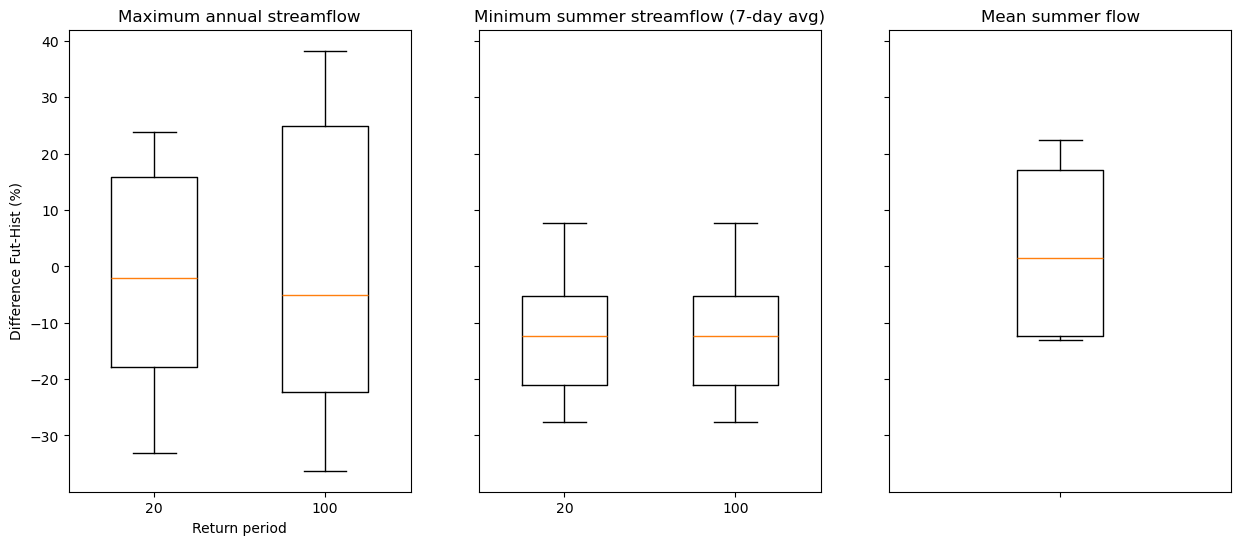

In [47]:
# Fake the boxplots based on the computes percentiles
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

ax = plt.subplot(1, 3, 1)
for i, rp in enumerate(ens_stats.return_period.values):
    stats = [
        {
            "label": rp,
            "med": ens_stats.streamflow_max_annual.sel(
                percentiles=50, return_period=rp
            ).values,
            "q1": ens_stats.streamflow_max_annual.sel(
                percentiles=25, return_period=rp
            ).values,
            "q3": ens_stats.streamflow_max_annual.sel(
                percentiles=75, return_period=rp
            ).values,
            "whislo": ens_stats.streamflow_max_annual.sel(
                percentiles=10, return_period=rp
            ).values,
            "whishi": ens_stats.streamflow_max_annual.sel(
                percentiles=90, return_period=rp
            ).values,
        }
    ]

    ax.bxp(stats, showfliers=False, positions=[i], widths=0.5)
ax.set_title("Maximum annual streamflow")
plt.xlabel("Return period")
plt.ylabel("Difference Fut-Hist (%)")

ax = plt.subplot(1, 3, 2)
for i, rp in enumerate(ens_stats.return_period.values):
    stats = [
        {
            "label": rp,
            "med": ens_stats.streamflow7_min_summer.sel(percentiles=50).values,
            "q1": ens_stats.streamflow7_min_summer.sel(percentiles=25).values,
            "q3": ens_stats.streamflow7_min_summer.sel(percentiles=75).values,
            "whislo": ens_stats.streamflow7_min_summer.sel(percentiles=10).values,
            "whishi": ens_stats.streamflow7_min_summer.sel(percentiles=90).values,
        }
    ]

    ax.bxp(stats, showfliers=False, positions=[i], widths=0.5)
ax.set_title("Minimum summer streamflow (7-day avg)")
plt.xlabel("")

ax = plt.subplot(1, 3, 3)
stats = [
    {
        "label": "",
        "med": ens_stats.qmoy_summer.sel(percentiles=50).values,
        "q1": ens_stats.qmoy_summer.sel(percentiles=25).values,
        "q3": ens_stats.qmoy_summer.sel(percentiles=75).values,
        "whislo": ens_stats.qmoy_summer.sel(percentiles=10).values,
        "whishi": ens_stats.qmoy_summer.sel(percentiles=90).values,
    }
]

ax.bxp(stats, showfliers=False, positions=[i], widths=0.25)
ax.set_title("Mean summer flow")

plt.show()

In [49]:
print(
    f"Fraction of simulations with a positive change (maximum streamflow): {ens_stats.streamflow_max_annual_positive.values}"
)
print(
    f"Fraction of simulations with a positive change (minimum summer streamflow): {ens_stats.streamflow7_min_summer_positive.values}"
)
print(
    f"Fraction of simulations with a positive change (mean summer streamflow): {ens_stats.qmoy_summer_positive.values}"
)

Fraction of simulations with a positive change (maximum streamflow): [0.35714286 0.42857143]
Fraction of simulations with a positive change (minimum summer streamflow): 0.21428571428571427
Fraction of simulations with a positive change (mean summer streamflow): 0.5714285714285714
